# Detectron Analysis

In [1]:
from exp.nb_detectron import *
from detectron2.utils.visualizer import ColorMode

In [2]:
checkpoint_path = Path('/workspace/oct_ca_seg/runsaves/01_pawsey/')

In [3]:
cfg = get_cfg()

In [4]:
cfg.merge_from_file(checkpoint_path/'01_OCTPawsey_model_mask_rcnn_R_50_FPN_3x.yaml')

In [5]:
cfg.MODEL.WEIGHTS = str(checkpoint_path/'model_final.pth') #can change model_final to a checkpoint to see as well

In [6]:
predictor = DefaultPredictor(cfg)

In [7]:
projectname = 'OCT'

In [8]:
data_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = data_path/'train'
valid_path = data_path/'valid'
test_path = data_path/'test'

## Datasets

In [9]:
trainCOCO = COCO(train_path/'images/annotations.json')
validCOCO = COCO(valid_path/'images/annotations.json')
testCOCO = COCO(test_path/'images/annotations.json')

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [10]:
trainDetectronDataset = load_coco_json(train_path/('images/annotations.json'), train_path/'images', dataset_name=train_path.name)
validDetectronDataset = load_coco_json(valid_path/('images/annotations.json'), valid_path/'images', dataset_name=valid_path.name)
testDetectronDataset = load_coco_json(test_path/('images/annotations.json'), test_path/'images', dataset_name=test_path.name)

In [11]:
for d in [train_path, valid_path, test_path]:
    DatasetCatalog.register(projectname + d.name,
                            lambda d=d: load_coco_json(d/('images/annotations.json'), d/'images', dataset_name=d.name))  #get_dicts(d.name))#
    MetadataCatalog.get(projectname+ d.name).set(stuff_classes=["lumen"])

In [12]:
train_metadata = MetadataCatalog.get(projectname+'train')
train_metadata.stuff_classes = ['lumen']
train_metadata.thing_classes = ['lumen']
valid_metadata = MetadataCatalog.get(projectname+'valid')
valid_metadata.stuff_classes = ['lumen']
valid_metadata.thing_classes = ['lumen']
test_metadata = MetadataCatalog.get(projectname+'test')
test_metadata.stuff_classes = ['lumen']
test_metadata.thing_classes = ['lumen']

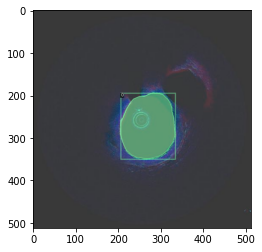

In [13]:
for d in random.sample(trainDetectronDataset, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('ABR_train'), scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

## Results

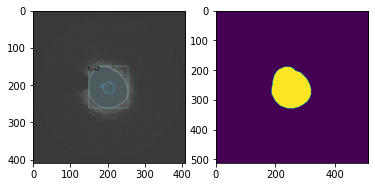

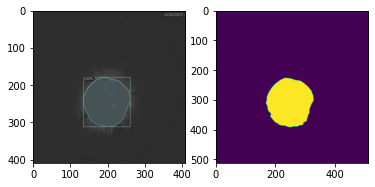

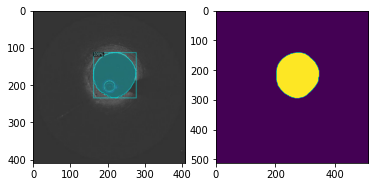

In [15]:
for d in random.sample(validDetectronDataset, 3):    
    im = cv2.imread(d["file_name"])
    #print(d.keys())
    
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=valid_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    fig, (ax1, ax2) = plt.subplots(1,2)
    image_plot = ax1.imshow(v.get_image()[:, :, ::-1])
    
    
    label_full = annsToSingleBinMask(validCOCO, d['image_id']) 
    label_plot = ax2.imshow(label_full)

### Validation

In [ ]:
%%time
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


cfg.MODEL.WEIGHTS = os.path.join(checkpoint_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)


coco_ev = COCOEvaluator(projectname+"valid", cfg, False, output_dir=cfg.OUTPUT_DIR)
OCT_ev = OCT_Evaluator(validCOCO)

evaluators = DatasetEvaluators([coco_ev, OCT_ev])
val_loader = build_detection_test_loader(cfg, projectname+"valid")
results = inference_on_dataset(predictor.model, val_loader, evaluators)

In [76]:
save_results(results, checkpoint_path/'results.json');

NameError: name 'json' is not defined

In [115]:
%%time
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


cfg.MODEL.WEIGHTS = os.path.join(checkpoint_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)


coco_ev = COCOEvaluator(projectname+"test", cfg, False, output_dir=cfg.OUTPUT_DIR)
OCT_ev = OCT_Evaluator(testCOCO)

evaluators = DatasetEvaluators([coco_ev, OCT_ev])
val_loader = build_detection_test_loader(cfg, projectname+"test")
test_results = inference_on_dataset(predictor.model, val_loader, evaluators)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.960
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [116]:
testa = Analysis(predictor, testDetectronDataset, test_results)

there were  0 zeros in the  dices  list.


2 0009691.jpg
0.9641042947769165


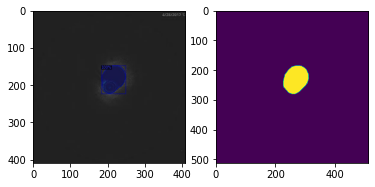

In [117]:
testa.showPrediction(2)

In [88]:
class Analysis():
    def __init__(self, predictor, validdataset, results):
        self.predictor = predictor
        self.valid = validdataset
        self.results = results
        self.topThresh = 0.9
        self.dices_zeros, self.dices = self.remove0FromMetric('dices')
    
    def processOutputsToMask(self, outputs):
        scores = outputs['instances'].scores
        if len(scores)==0: 
            return torch.zeros(outputs['instances'].image_size).unsqueeze(0).cuda()
        else:
            good_indices = [i for i,x in enumerate(outputs['instances'].scores) if x>self.topThresh]
            if not good_indices: good_indices= [torch.argmax(scores).item()]
            #good_indices = torch.tensor(good_indices, dtype=torch.long).cuda()
        #print(good_indices)
        #print(outputs['instances'].pred_masks.size())
        mask = outputs['instances'].pred_masks.clone().detach()[good_indices]
        #mask = torch.index_select(outputs['instances'].pred_masks.clone().detach(), 0, good_indices)
        mask = mask.int().sum(dim=0).unsqueeze(0).cuda()
        mask = (mask>0).float()
        return mask
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self,metric):
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        return l_actual
    
    def showPrediction(self, id):
        d = validCOCO.imgs[id]
        im = cv2.imread(d["file_name"])
        print(id, Path(d["file_name"]).name)

        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=valid_metadata, 
                       scale=0.8, 
                       instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
                      )

        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        fig, (ax1, ax2) = plt.subplots(1,2)
        image_plot = ax1.imshow(v.get_image()[:, :, ::-1])
        
        label_full = annsToSingleBinMask(validCOCO, d['image_id']) 
        dice_loss = lossdice(self.processOutputsToMask(outputs).cpu(), torch.tensor(label_full)).item()
        label_plot = ax2.imshow(label_full)
        print(dice_loss)

there were  0 zeros in the  dices  list.
0.5106942529181341 0.16395778172247627 0.5126009583473206 0.9286260008811951 0.10646269470453262


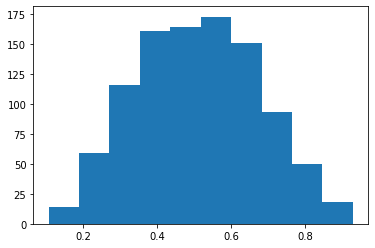

In [118]:
lll = testa.histPlotMetric('dices')

### Test

In [89]:
analysis = Analysis(predictor, validDetectronDataset, results)

there were  0 zeros in the  dices  list.


there were  0 zeros in the  dices  list.
0.980220052299822 0.019771950076024516 0.9847640693187714 0.993000864982605 0.6656062006950378


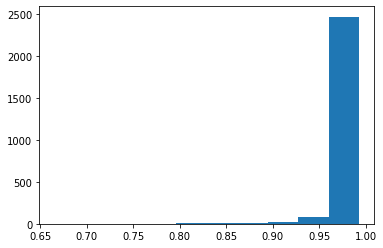

In [90]:
dices = analysis.histPlotMetric('dices')

In [98]:
results['dices']

{1: 0.9346874356269836,
 2: 0.9651556015014648,
 3: 0.9837164282798767,
 4: 0.9850432872772217,
 5: 0.98663330078125,
 6: 0.9887834191322327,
 7: 0.9828300476074219,
 8: 0.9365841150283813,
 9: 0.9858953356742859,
 10: 0.9872466325759888,
 11: 0.9857232570648193,
 12: 0.9874439239501953,
 13: 0.9904244542121887,
 14: 0.9833643436431885,
 15: 0.9835517406463623,
 16: 0.9885575175285339,
 17: 0.9863703846931458,
 18: 0.9890857338905334,
 19: 0.9885002374649048,
 20: 0.9258034825325012,
 21: 0.98479825258255,
 22: 0.9830766320228577,
 23: 0.9859576225280762,
 24: 0.9833550453186035,
 25: 0.9613523483276367,
 26: 0.9882138967514038,
 27: 0.989203929901123,
 28: 0.9822268486022949,
 29: 0.9282807111740112,
 30: 0.9882352948188782,
 31: 0.9874546527862549,
 32: 0.9822989106178284,
 33: 0.9858198165893555,
 34: 0.9895503520965576,
 35: 0.9871198534965515,
 36: 0.988599956035614,
 37: 0.9854525923728943,
 38: 0.9865542650222778,
 39: 0.9875931739807129,
 40: 0.983321487903595,
 41: 0.988535106

1 0010696.jpg
0.9341561794281006


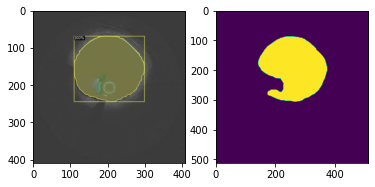

In [95]:
analysis.showPrediction(1)